In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

*   n: sample size
*   d: covariate dimension
*   s: noise level $\sigma_{\varepsilon}^2$
*   l: regularisation $\lambda$

_____________________________________________________________________________



Training data $X\in\mathbb{R}^{n\times d}$ satisfies
$$
  x_i \sim \mathcal{N}(0, \Sigma)
$$
where ${x_i^\top}$ s are the rows of $X$, independent to each other.
__________________________________________________________________________

Quadratic term
$$\lambda^2\|\Lambda^{1/2}(X^\top X + \lambda)^{-1}\beta_*\|_{2}^2$$
and its equivalence
$$
\lambda_*^2\langle \beta_*, (\Sigma+\lambda_*)^{-1} \Lambda (\Sigma+\lambda_*)^{-1} \beta_*\rangle + \frac{\lambda_*^2 \text{Tr}(\Lambda \Sigma (\Sigma+\lambda_*)^{-2})}{n-\text{Tr}(\Sigma^2(\Sigma+\lambda_*)^{-2})}\langle \beta_*, \Sigma(\Sigma+\lambda_*)^{-2}\beta_*\rangle
$$
__________________________________________________________________________

Cross term
$$
2\lambda \langle \theta_* - \beta_*, \Lambda (X^\top X + \lambda)^{-1} \beta_*\rangle
$$
and its equivalence
$$
2\lambda_* \langle \theta_*-\beta_*, \Lambda(\Sigma+\lambda_*)^{-1}\beta_*\rangle
$$
__________________________________________________________________________

Variance
$$
\sigma_{\varepsilon}^2 \text{Tr}(\Lambda X^\top X (X^\top X + \lambda)^{-2})
$$
and its equivalence
$$
\sigma_{\varepsilon}^2\frac{\text{Tr}(\Lambda\Sigma(\Sigma+\lambda_*)^{-2})}{n-\text{Tr}(\Sigma^2(\Sigma+\lambda_*)^{-2})}
$$
__________________________________________________________________________

Bias
$$
  \|\Lambda^{1/2}(\theta_*-(X^\top X-\lambda)^{-1} X^\top X\beta_*)\|_2^2
$$
and its deterministic equivalence
$$
  \|\Lambda^{1/2}(\theta_* - \beta_*)\|_2^2+\lambda_*^2\langle\beta_*, (\Sigma+\lambda_*)^{-1}\Lambda(\Sigma+\lambda_*)^{-1}\beta_*\rangle + \frac{\lambda_*^2\text{Tr}(\Lambda\Sigma(\Sigma+\lambda_*)^{-2})}{n-\text{Tr}(\Sigma^2(\Sigma+\lambda_*)^{-2})}\langle \beta_*, \Sigma(\Sigma+\lambda_*)^{-2}\beta_*\rangle + 2\lambda_*\langle \theta_*-\beta_*, \Lambda(\Sigma+\lambda_*)^{-1}\beta_*\rangle
$$

In [2]:
def generate_beta(d):
  return np.random.randn(d)

def generate_theta(d):
  return np.random.randn(d)

def generate_Sigma(d):
  X = np.random.randn(d, d)
  return X @ X.T

def generate_Lambda(d):
  X = np.random.randn(d, d)
  return X @ X.T

def generate_Training_Data(n, d, Sigma):
  X = np.random.multivariate_normal(mean=np.zeros(d), cov=Sigma, size=n)
  return X

def generate_Sigma_and_Lambda(d):
  X = np.random.randn(d, d)
  Q, _ = np.linalg.qr(X)
  D_1 = np.diag(evals_Sigma)
  D_2 = np.diag(evals_Lambda)
  return Q @ D_1 @ Q.T, Q @ D_2 @ Q.T

from scipy.optimize import bisect

def lambda_star(evals, l, n):
    f = lambda lstar: n - l/lstar - np.sum(evals / (evals + lstar))
    return bisect(f, 1e-12*l, 1e6*l)

def Quadratic(X, Lambda, beta, l):
  Y = np.linalg.inv(X.T @ X + l*np.eye(X.shape[1]))
  return l**2 * beta.T @ Y @ Lambda @ Y @ beta

def Quadratic_Equiv(Sigma, Lambda, beta, n, l_star):
  A = np.linalg.inv(Sigma + l_star*np.eye(Sigma.shape[0]))

  first_term = l_star**2 * beta.T @ A @ Lambda @ A @ beta
  second_term = l_star**2 * np.trace(Lambda @ Sigma @ A @ A) * (beta.T @ Sigma @ A @ A @ beta) / (n - np.trace(Sigma @ Sigma @ A @ A))

  return first_term + second_term

def Cross(X, Lambda, theta, beta, l):
  Y = np.linalg.inv(X.T @ X + l*np.eye(X.shape[1]))
  return 2 * l * np.dot(theta - beta, Lambda @ Y @ beta)

def Cross_Equiv(Sigma, Lambda, theta, beta, l_star):
  A = np.linalg.inv(Sigma+l_star*np.eye(Sigma.shape[0]))
  return 2 * l_star * (theta - beta).T @ Lambda @ A @ beta

def Vars(X, Lambda, l, s):
  Y = np.linalg.inv(X.T @ X + l*np.eye(X.shape[1]))
  Z = X.T @ X
  return s * np.trace(Lambda @ Z @ Y @ Y)

def Vars_Equiv(Lambda, Sigma, l_star, s, n):
  A = np.linalg.inv(Sigma+l_star*np.eye(Sigma.shape[0]))
  return s * np.trace(Lambda @ Sigma @ A @ A) / (n - np.trace(Sigma @ Sigma @ A @ A))

def Bias(X, Lambda, theta, beta, l):
  Y = np.linalg.inv(X.T @ X + l*np.eye(X.shape[1]))
  Z = X.T @ X
  return (theta - Y @ Z @ beta).T @ Lambda @ (theta - Y @ Z @ beta)

def Bias_Equiv(Sigma, Lambda, theta, beta, l_star, l, n):
  first_term = (theta - beta).T @ Lambda @ (theta - beta)
  quadratic_equiv = Quadratic_Equiv(Sigma, Lambda, beta, n, l_star)
  cross_equiv = Cross_Equiv(Sigma, Lambda, theta, beta, l_star)

  return first_term + quadratic_equiv + cross_equiv

def First_Term(Lambda, theta, beta):
  return (theta - beta).T @ Lambda @ (theta - beta)

def T3_actual(Lambda, Sigma, X, beta, theta, l, l_star):
  Y = np.linalg.inv(X.T @ X + l * np.eye(X.shape[1]))
  A = np.linalg.inv(Sigma + l_star * np.eye(Sigma.shape[0]))

  return 2 * np.abs(l * ((theta-beta).T @ Lambda @ Y @ beta) - l_star * ((theta-beta).T @ Lambda @ A @ beta))

def T3_pred(Lambda, Sigma, beta, theta, l_star):
  A = np.linalg.inv(Sigma + l_star * np.eye(Sigma.shape[0]))
  return 2 * l_star * np.sqrt( ((theta-beta) @ Lambda @ A @ Lambda @ (theta-beta)) * (beta @ A @ beta) )

**Now compute variance and its deterministic equivalence**

For convenience, assume $\Sigma$ has eigenvalues $1/k^{\alpha_1}$ and $\Lambda$ has eigenvalues $1/k^{\alpha_2}$ for $1\leq k\leq d$, and they have the same eigenvectors

From the experiments, the deterministic equivalence gives a quite accurate prediction of the **Variance**

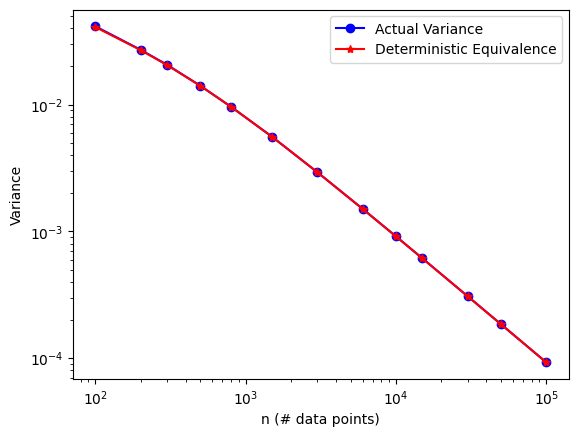

In [3]:
import matplotlib.pyplot as plt
n_vals = [100, 200, 300, 500, 800, 1500, 3000, 6000, 10000, 15000, 30000, 50000, 100000]
#n_vals = [100, 200]
rept = 20
d = 100
s = 0.5
l = 0.5
alpha1 = 1.5
alpha2 = 2
evals_Sigma = 1/(np.arange(1, d+1) ** alpha1)
evals_Lambda = 1/(np.arange(1, d+1) ** alpha2)

beta = generate_beta(d)
theta = generate_theta(d)
Sigma, Lambda= generate_Sigma_and_Lambda(d)

actual_mean = []
actual_sd = []
pred = []

for n in n_vals:
  l_star = lambda_star(evals_Sigma, l, n)
  temp_actual = []
  for r in range(rept):
    X = generate_Training_Data(n, d, Sigma)
    actual_vars = Vars(X, Lambda, l, s)
    temp_actual.append(actual_vars)

  temp_actual = np.array(temp_actual)
  actual_mean.append(np.mean(temp_actual))
  actual_sd.append(np.sqrt(np.var(temp_actual)))
  pred_vars = Vars_Equiv(Lambda, Sigma, l_star, s, n)
  pred.append(pred_vars)

actual_mean = np.array(actual_mean)
actual_sd = np.array(actual_sd)
pred = np.array(pred)

plt.plot(n_vals, actual_mean, marker = 'o', color = 'b', label = 'Actual Variance')
#plt.fill_between(n_vals, actual_mean - actual_sd, actual_mean + actual_sd, color='blue', alpha=0.2, label='±1 Std. Dev.')
plt.plot(n_vals, pred, marker = '*', color = 'r', label = 'Deterministic Equivalence')
#plt.plot(n_vals, actual_mean/pred, marker = '.', color = 'purple', label = 'Ratio between actual and prediction')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('n (# data points)')
plt.ylabel('Variance')
plt.legend()
plt.show()

**Now compute bias and its deterministic equivalence**

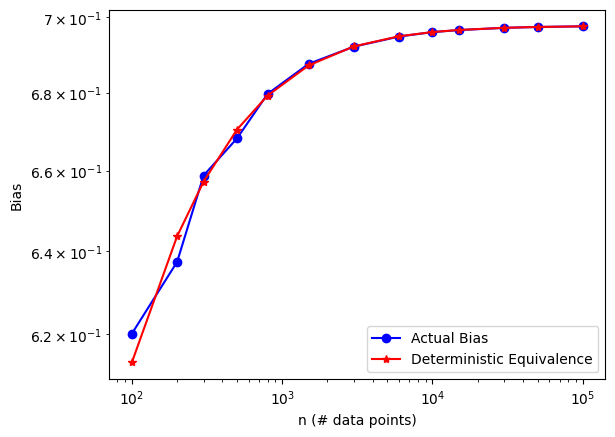

In [4]:
import matplotlib.pyplot as plt
n_vals = [100, 200, 300, 500, 800, 1500, 3000, 6000, 10000, 15000, 30000, 50000, 100000]
#n_vals = [100, 200]
rept = 20
d = 100
s = 0.5
l = 0.5
alpha1 = 1.5
alpha2 = 2
evals_Sigma = 1/(np.arange(1, d+1) ** alpha1)
evals_Lambda = 1/(np.arange(1, d+1) ** alpha2)

beta = generate_beta(d)
theta = generate_theta(d)
#theta = beta + 0.01 * np.random.randn(d)
#theta = beta
Sigma, Lambda= generate_Sigma_and_Lambda(d)

actual_mean = []
actual_sd = []
pred = []


for n in n_vals:
  l_star = lambda_star(evals_Sigma, l, n)
  temp_actual = []

  for r in range(rept):
    X = generate_Training_Data(n, d, Sigma)
    actual_bias = Bias(X, Lambda, theta, beta, l)
    temp_actual.append(actual_bias)

  temp_actual = np.array(temp_actual)
  actual_mean.append(np.mean(temp_actual))
  actual_sd.append(np.sqrt(np.var(temp_actual)))
  pred_bias = Bias_Equiv(Sigma, Lambda, theta, beta, l_star, l, n)
  pred.append(pred_bias)

actual_mean = np.array(actual_mean)
actual_sd = np.array(actual_sd)
pred = np.array(pred)




plt.plot(n_vals, actual_mean, marker = 'o', color = 'b', label = 'Actual Bias')
#plt.fill_between(n_vals, actual_mean - actual_sd, actual_mean + actual_sd, color='blue', alpha=0.2, label='±1 Std. Dev.')
plt.plot(n_vals, pred, marker = '*', color = 'r', label = 'Deterministic Equivalence')
#plt.plot(n_vals, actual_mean/pred, marker = '.', color = 'purple', label = 'Ratio between actual and prediction')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('n (# data points)')
plt.ylabel('Bias')
plt.legend()
plt.show()

**The quadratic term in the bias and its deterministic equivalence**

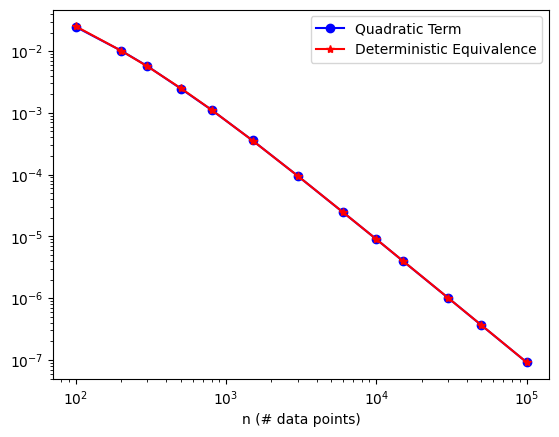

In [5]:
import matplotlib.pyplot as plt
n_vals = [100, 200, 300, 500, 800, 1500, 3000, 6000, 10000, 15000, 30000, 50000, 100000]
#n_vals = [100, 200]
rept = 20
d = 100
s = 0.5
l = 0.5
alpha1 = 1.5
alpha2 = 2
evals_Sigma = 1/(np.arange(1, d+1) ** alpha1)
evals_Lambda = 1/(np.arange(1, d+1) ** alpha2)

beta = generate_beta(d)
theta = generate_theta(d)
#theta = beta + 0.01*np.random.randn(d)
Sigma, Lambda= generate_Sigma_and_Lambda(d)

actual_mean = []
actual_sd = []
pred = []

for n in n_vals:
  l_star = lambda_star(evals_Sigma, l, n)
  temp_actual = []
  for r in range(rept):
    X = generate_Training_Data(n, d, Sigma)
    actual_quadratic = Quadratic(X, Lambda, beta, l)
    temp_actual.append(actual_quadratic)

  temp_actual = np.array(temp_actual)
  actual_mean.append(np.mean(temp_actual))
  actual_sd.append(np.sqrt(np.var(temp_actual)))
  pred_quadratic = Quadratic_Equiv(Sigma, Lambda, beta, n, l_star)
  pred.append(pred_quadratic)

actual_mean = np.array(actual_mean)
actual_sd = np.array(actual_sd)
pred = np.array(pred)

plt.plot(n_vals, actual_mean, marker = 'o', color = 'b', label = 'Quadratic Term')
#plt.fill_between(n_vals, actual_mean - actual_sd, actual_mean + actual_sd, color='blue', alpha=0.2, label='±1 Std. Dev.')
plt.plot(n_vals, pred, marker = '*', color = 'r', label = 'Deterministic Equivalence')
#plt.plot(n_vals, actual_mean/pred, marker = '.', color = 'purple', label = 'Ratio between actual and prediction')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('n (# data points)')
#plt.ylabel('Bias')
plt.legend()
plt.show()

**The cross term in the bias and its deterministic equivalence**

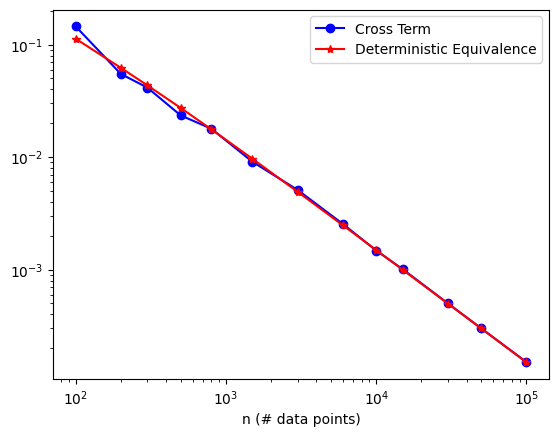

In [6]:
import matplotlib.pyplot as plt
n_vals = [100, 200, 300, 500, 800, 1500, 3000, 6000, 10000, 15000, 30000, 50000, 100000]
#n_vals = [100, 200]
rept = 20
d = 100
s = 0.5
l = 0.5
alpha1 = 1.5
alpha2 = 2
evals_Sigma = 1/(np.arange(1, d+1) ** alpha1)
evals_Lambda = 1/(np.arange(1, d+1) ** alpha2)

beta = generate_beta(d)
theta = generate_theta(d)
#theta = beta + 0.01*np.random.randn(d)
Sigma, Lambda= generate_Sigma_and_Lambda(d)

actual_mean = []
actual_sd = []
pred = []

for n in n_vals:
  l_star = lambda_star(evals_Sigma, l, n)
  temp_actual = []
  for r in range(rept):
    X = generate_Training_Data(n, d, Sigma)
    actual_cross = Cross(X, Lambda, theta, beta, l)
    temp_actual.append(actual_cross)

  temp_actual = np.array(temp_actual)
  actual_mean.append(np.mean(temp_actual))
  actual_sd.append(np.sqrt(np.var(temp_actual)))
  pred_cross = Cross_Equiv(Sigma, Lambda, theta, beta, l_star)
  pred.append(pred_cross)

actual_mean = np.array(np.abs(actual_mean))
actual_sd = np.array(actual_sd)
pred = np.array(np.abs(pred))

plt.plot(n_vals, actual_mean, marker = 'o', color = 'b', label = 'Cross Term')
#plt.fill_between(n_vals, actual_mean - actual_sd, actual_mean + actual_sd, color='blue', alpha=0.2, label='±1 Std. Dev.')
plt.plot(n_vals, pred, marker = '*', color = 'r', label = 'Deterministic Equivalence')
#plt.plot(n_vals, actual_mean/pred, marker = '.', color = 'purple', label = 'Ratio between actual and prediction')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('n (# data points)')
#plt.ylabel('Bias')
plt.legend()
plt.show()

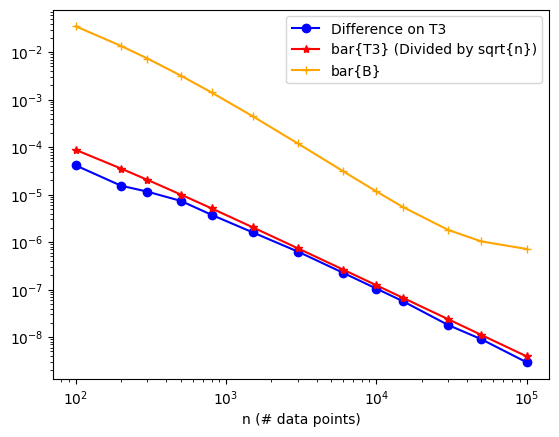

In [7]:
import matplotlib.pyplot as plt
n_vals = [100, 200, 300, 500, 800, 1500, 3000, 6000, 10000, 15000, 30000, 50000, 100000]
#n_vals = [100, 200]
rept = 20
d = 100
s = 0.5
l = 0.5
alpha1 = 1.5
alpha2 = 2
evals_Sigma = 1/(np.arange(1, d+1) ** alpha1)
evals_Lambda = 1/(np.arange(1, d+1) ** alpha2)

beta = generate_beta(d)
#theta = generate_theta(d)
theta = beta + 0.001*np.random.randn(d)
Sigma, Lambda= generate_Sigma_and_Lambda(d)

actual_mean = []
actual_sd = []
pred = []
pred_b = []

for n in n_vals:
  l_star = lambda_star(evals_Sigma, l, n)
  temp_actual = []
  for r in range(rept):
    X = generate_Training_Data(n, d, Sigma)
    actual_T3 = T3_actual(Lambda, Sigma, X, beta, theta, l, l_star)
    temp_actual.append(actual_T3)

  temp_actual = np.array(temp_actual)
  actual_mean.append(np.mean(temp_actual))
  actual_sd.append(np.sqrt(np.var(temp_actual)))
  pred_T3 = T3_pred(Lambda, Sigma, beta, theta, l_star)
  pred.append(pred_T3 / np.sqrt(n))
  pred_bias = Bias_Equiv(Sigma, Lambda, theta, beta, l_star, l, n)
  pred_b.append(pred_bias)


actual_mean = np.array(actual_mean)
actual_sd = np.array(actual_sd)
pred = np.array(pred)
pred_b = np.array(pred_b)

plt.plot(n_vals, actual_mean, marker = 'o', color = 'b', label = 'Difference on T3')
#plt.fill_between(n_vals, actual_mean - actual_sd, actual_mean + actual_sd, color='blue', alpha=0.2, label='±1 Std. Dev.')
plt.plot(n_vals, pred, marker = '*', color = 'r', label = 'bar{T3} (Divided by sqrt{n})')
plt.plot(n_vals, pred_b, marker = '+', color = 'orange', label = 'bar{B}')
#plt.plot(n_vals, actual_mean/pred, marker = '.', color = 'purple', label = 'Ratio between actual and prediction')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('n (# data points)')
#plt.ylabel('Bias')
plt.legend()
plt.show()